In [242]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import math
import plotly.express as px

from matplotlib import dates as mpl_dates
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score, mean_gamma_deviance
from itertools import cycle


In [243]:
data = 'AYALY'
df = yf.download(tickers=data, period='2y', interval='1d')

[*********************100%***********************]  1 of 1 completed


In [244]:
df.isnull().sum()
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000
mean,15.203081,15.207097,15.202863,15.205765,15.056566,162.624254
std,1.687930,1.687192,1.687903,1.686022,1.641646,1857.287432
min,10.760000,10.760000,10.760000,10.760000,10.699000,0.000000
25%,14.650000,14.650000,14.650000,14.650000,14.462601,0.000000
50%,15.410000,15.410000,15.410000,15.410000,15.193402,0.000000
75%,16.230000,16.230000,16.230000,16.230000,16.001877,0.000000
max,18.480000,18.480000,18.480000,18.480000,18.220251,39600.000000


In [245]:
df.reset_index(inplace=True)
df_adj_close=df['Adj Close']

In [246]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df_adj_close=scaler.fit_transform(np.array(df_adj_close).reshape(-1,1))
df_adj_close.shape

(503, 1)

In [247]:
train_size=int(len(df_adj_close)*0.70)
test_size=len(df_adj_close)-train_size
train_data=df_adj_close[0:train_size,:]
test_data=df_adj_close[train_size:len(df_adj_close),:1]

In [248]:
def new_dataset(df2, time_step=1):
    x_data, y_data = [], []
    
    for i in range(len(df2)-time_step-1): 
        x_data.append(df2[i:(i+time_step), 0])
        y_data.append(df2[i + time_step, 0])
    return np.array(x_data), np.array(y_data)

In [249]:
time_step= 60
X_train, y_train= new_dataset(train_data, time_step)
X_test, y_test= new_dataset(test_data, time_step)

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [250]:
model=Sequential()
model.add(LSTM(20,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(20,return_sequences=True))
model.add(LSTM(20))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 60, 20)            1760      
                                                                 
 lstm_31 (LSTM)              (None, 60, 20)            3280      
                                                                 
 lstm_32 (LSTM)              (None, 20)                3280      
                                                                 
 dense_10 (Dense)            (None, 1)                 21        
                                                                 
Total params: 8,341
Trainable params: 8,341
Non-trainable params: 0
_________________________________________________________________


In [251]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=165,batch_size=32,verbose=1)

Epoch 1/165
10/10 [==============================] - 6s 181ms/step - loss: 0.2263 - val_loss: 0.0336
Epoch 2/165
10/10 [==============================] - 1s 59ms/step - loss: 0.0240 - val_loss: 0.0906
Epoch 3/165
10/10 [==============================] - 1s 59ms/step - loss: 0.0104 - val_loss: 0.0376
Epoch 4/165
10/10 [==============================] - 1s 59ms/step - loss: 0.0131 - val_loss: 0.0567
Epoch 5/165
10/10 [==============================] - 1s 60ms/step - loss: 0.0096 - val_loss: 0.0619
Epoch 6/165
10/10 [==============================] - 1s 60ms/step - loss: 0.0084 - val_loss: 0.0468
Epoch 7/165
10/10 [==============================] - 1s 61ms/step - loss: 0.0078 - val_loss: 0.0519
Epoch 8/165
10/10 [==============================] - 1s 60ms/step - loss: 0.0076 - val_loss: 0.0458
Epoch 9/165
10/10 [==============================] - 1s 59ms/step - loss: 0.0071 - val_loss: 0.0435
Epoch 10/165
10/10 [==============================] - 1s 59ms/step - loss: 0.0069 - val_loss: 0.039

In [252]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [253]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

15.151396427085986

In [254]:
math.sqrt(mean_squared_error(y_test,test_predict))

12.535618556408187

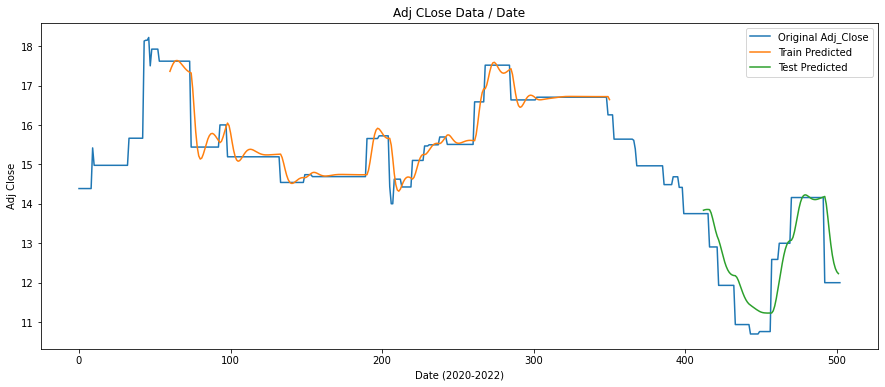

In [255]:
look_back=60
trainPredictPlot= np.empty_like(df_adj_close)
trainPredictPlot[:, :]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :]= train_predict
testPredictPlot = np.empty_like(df_adj_close)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_adj_close)-1, :] = test_predict
plt.title("Adj CLose Data / Date")
plt.xlabel("Date (2020-2022)")
plt.ylabel("Adj Close")
plt.plot(scaler.inverse_transform(df_adj_close))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.gca().legend(('Original Adj_Close','Train Predicted','Test Predicted'))
plt.rcParams['figure.figsize'] = [15, 6]
plt.show()

In [256]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

((291, 1), (90, 1))

In [257]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [258]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp=list(x_input)
temp=temp[0].tolist()
from numpy import array
lst_output=[]
n_steps=time_step
i=0
pred_days= 8
while(i<pred_days):
    if(len(temp)>time_step):
        x_input=np.array(temp[1:])
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp.extend(yhat[0].tolist())
        temp=temp[1:]       
        lst_output.extend(yhat.tolist())
        i=i+1     
    else: 
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1

In [259]:
print("Days to be Predict: ", len(lst_output))

Days to be Predict:  8


In [260]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)

In [261]:
forec= np.empty((len(last_days)+pred_days+1,1))
forec[:]= np.nan
forec= forec.reshape(1,-1).tolist()[0]
last_original_days_value= forec
next_predicted_days_value= forec
last_original_days_value[0:time_step+1]= scaler.inverse_transform(df_adj_close[len(df_adj_close)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:]= scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
new_pred_plot= pd.DataFrame({'last_original_days_value':last_original_days_value,'next_predicted_days_value':next_predicted_days_value})
names= cycle(['Last 2 weeks close price','Predicted next 8 days close price'])
fig= px.line(new_pred_plot,x=new_pred_plot.index,
            y=[new_pred_plot['last_original_days_value'],
            new_pred_plot['next_predicted_days_value']],
            labels={'value': 'Stock price','index': 'Day'})
fig.update_layout(title_text='Last 2 weeks vs next 8 days',
plot_bgcolor='black', font_size=10, font_color='black',legend_title_text='Adj_Close Price')
fig.for_each_trace(lambda t:  t.update(name= next(names)))
fig.show()

In [263]:
outputcsv = pd.DataFrame(forec, columns = ['Prediction']).to_csv('/content/DeGuzman_AC_forecast.csv')